# 1. Preprocessing

## 1.1 Loading libraries and dataset

In [10]:
import json
import os
from pathlib import Path
from os.path import join
from os import listdir

import kagglehub
import pandas as pd
import numpy as np
from tqdm import tqdm

os.chdir('/teamspace/studios/this_studio/kaggle/kaggle_auth')
print(os.getcwd())

from kaggle_auth import auth
auth()

os.chdir('/teamspace/studios/this_studio/ai-capstone-proj')
print(os.getcwd())

import src.utils as u
import src.constants as c
import src.balanced.dataset_processing as bdp



/teamspace/studios/this_studio/kaggle/kaggle_auth
/teamspace/studios/this_studio/ai-capstone-proj


In [13]:
import os
os.getcwd()

'/teamspace/studios/this_studio/ai-capstone-proj'

In [12]:
cwd = Path().absolute().parent

kagglehub.auth.whoami()
kagglepath = kagglehub.dataset_download('arct22/codebrim-balanced')

org_imgs_merged = join(cwd, 'datasets', 'org', 'images')
pad_images = join(cwd, 'datasets', 'pad', 'images')
pad_labels = join(cwd, 'datasets', 'pad', 'labels')
print(kagglepath)

Kaggle credentials successfully validated.


/teamspace/studios/this_studio/.cache/kagglehub/datasets/arct22/codebrim-balanced/versions/2


In [10]:
def list_all_folders(path):
    base_path = Path(path)
    return [str(p.relative_to(base_path)) for p in base_path.rglob("*") if p.is_dir()]


list_all_folders(kagglepath)

['metadata',
 'test',
 'train',
 'val',
 'test/background',
 'test/defects',
 'train/background',
 'train/defects',
 'val/background',
 'val/defects']

We can see that dataset subdirectories train, test and val have separate subfolders for backgrounds and defects. We will merge them, since YOLO will be not able to recognize such folder structure.

In [11]:
copiedpaths = bdp.copy_bg_and_defects(kagglepath, org_imgs_merged)

path /teamspace/studios/this_studio/datasets/org/images/val already exists. Skipping copying operation
path /teamspace/studios/this_studio/datasets/org/images/test already exists. Skipping copying operation
path /teamspace/studios/this_studio/datasets/org/images/train already exists. Skipping copying operation


In [12]:
bg_xml = u.xml_to_dict(join(kagglepath, 'metadata', 'background.xml'))['Annotation']['Defect']
defects_xml = u.xml_to_dict(join(kagglepath, 'metadata', 'defects.xml'))['Annotation']['Defect']

org_bg_df = pd.DataFrame(bg_xml)
org_defects_df = pd.DataFrame(defects_xml)
org_df = pd.concat([org_bg_df, org_defects_df])

org_df = org_df.rename(columns={'@name': c.IMG})
org_df[c.defect_names] = org_df[c.defect_names].astype(np.uint8)
org_df

,img,Background,Crack,Spallation,Efflorescence,ExposedBars,CorrosionStain
0,image_0000001_crop_0000001.png,1,0,0,0,0,0
1,image_0000001_crop_0000002.png,1,0,0,0,0,0
2,image_0000001_crop_0000003.png,1,0,0,0,0,0
3,image_0000001_crop_0000004.png,1,0,0,0,0,0
4,image_0000001_crop_0000005.png,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7967,image_0001599_crop_0000005_copy00.png,0,0,1,0,1,1
7968,image_0001599_crop_0000006_copy00.png,0,0,1,0,1,1
7969,image_0001599_crop_0000008_copy00.png,0,0,0,1,0,1
7970,image_0001599_crop_0000008_copy01.png,0,0,0,1,0,1


## 1.2 Data Exploration

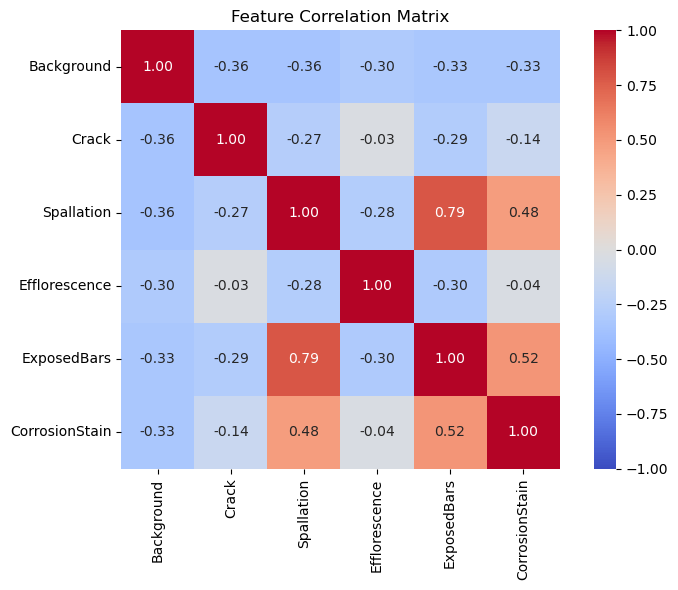


Strongest Correlations:
Spallation - ExposedBars: 0.787
ExposedBars - CorrosionStain: 0.523
Spallation - CorrosionStain: 0.478
Background - Spallation: -0.359
Background - Crack: -0.357


In [13]:
bdp.plot_corr_matrix(org_df, (8, 6))

The correlation matrix reveals logical relationships between defect classes- for ex. there is no corrosion stains without exposed reinforcement bars, and bars can be only exposed, if conrete is spalted. This indicates, that data collection methodology was collected correctly, showing that images were correctly annotated.

We can see that maximal correlation for between features exists for pair Spallation - ExposedBars- 0.787. In addition, we can also see high correlation between those two defect types and CorrosionStain (0.478 and 0.523, respectivelly). Again,

We will merge these three columns to reduce number of classes that model will have to detect.

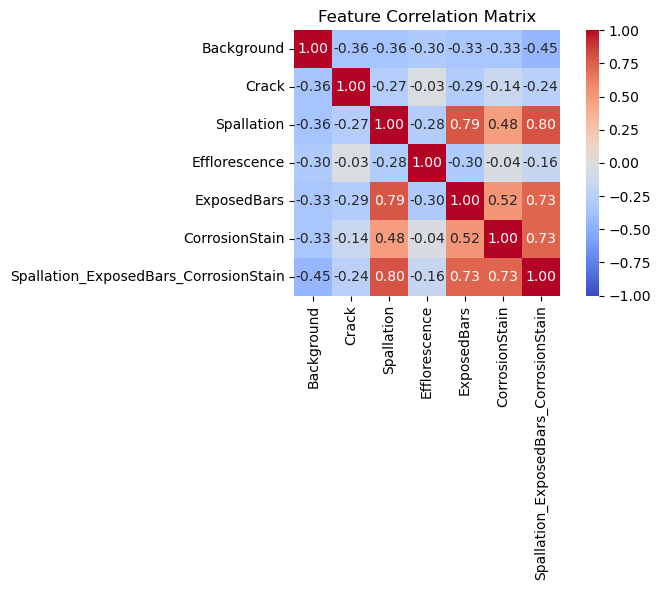


Strongest Correlations:
Spallation - Spallation_ExposedBars_CorrosionStain: 0.800
Spallation - ExposedBars: 0.787
ExposedBars - Spallation_ExposedBars_CorrosionStain: 0.733
CorrosionStain - Spallation_ExposedBars_CorrosionStain: 0.731
ExposedBars - CorrosionStain: 0.523


In [14]:
merged_cols = [c.SPALLATION, c.EXPOSEDBARS, c.CORROSIONSTAIN]

merged_col_name = "_".join(col for col in merged_cols)
org_df[merged_col_name] = (org_df[merged_cols[0]] | org_df[merged_cols[1]] | org_df[merged_cols[2]])
bdp.plot_corr_matrix(org_df, (8, 6))

Our new feature strongly correlates with original features, what indicates that it is able to correctly capture relationships between these defect types. Thus, we can safely drop original columns.

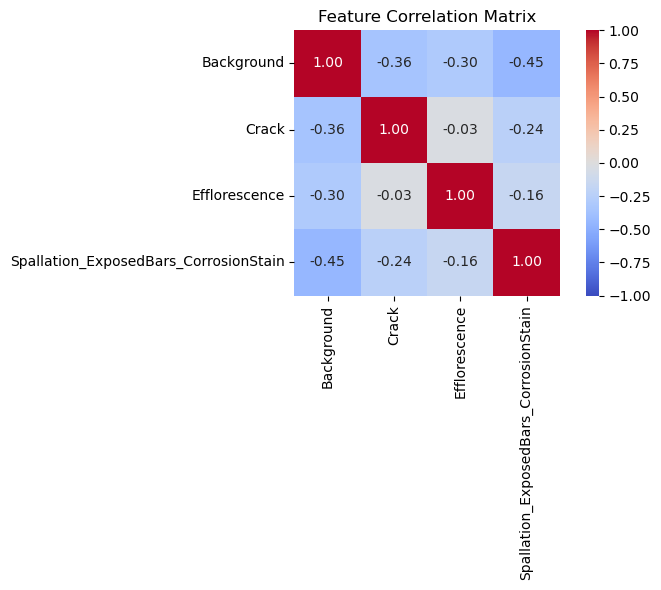


Strongest Correlations:
Background - Spallation_ExposedBars_CorrosionStain: -0.449
Background - Crack: -0.357
Background - Efflorescence: -0.303
Crack - Spallation_ExposedBars_CorrosionStain: -0.240
Efflorescence - Spallation_ExposedBars_CorrosionStain: -0.157


In [15]:
org_df = org_df.drop(merged_cols, axis=1)
bdp.plot_corr_matrix(org_df, (8, 6))

By applying dimensionality reduction, we were able to reduce amount of possible combinations from 33 to 9.

Let's see now how many times each combination of defects appears in dataset.

In [16]:
numerical_cols = org_df.select_dtypes(include=np.number).columns.tolist()

combination_counts = org_df.groupby(numerical_cols).size().reset_index(name='count')

# Sort by count in descending order
combination_counts = combination_counts.sort_values('count', ascending=False)
combination_counts

,Background,Crack,Efflorescence,Spallation_ExposedBars_CorrosionStain,count
1,0,0,0,1,3149
8,1,0,0,0,2490
4,0,1,0,0,2036
2,0,0,1,0,1420
6,0,1,1,0,360
5,0,1,0,1,360
3,0,0,1,1,324
7,0,1,1,1,271
0,0,0,0,0,52


We can see that three is combination [0, 0, 0, 0] which is rarest of all combinations (only 52 times). Since this is undefined type of defect, we will drop rows with these values.

In [17]:
rows_to_drop = ~(org_df[numerical_cols] == [0, 0, 0, 0]).all(axis=1)
org_df_filtered = org_df[rows_to_drop].copy()

Now, we will map a numerical value to each combination.

In [18]:
# First, make sure to get the combinations correctly
combinations = org_df_filtered[numerical_cols].value_counts().index.tolist()

# Print to check what we have
print("Combinations:", combinations)

# Only then create the mapping
mapping = {comb: i for i, comb in enumerate(combinations)}

# Create the new column
org_df_filtered['combination_id'] = org_df_filtered[numerical_cols].apply(tuple, axis=1).map(mapping)

Combinations: [(0, 0, 0, 1), (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0), (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1), (0, 1, 1, 1)]


In [19]:
org_df_filtered[numerical_cols].sum()

Background                               2490
Crack                                    3027
Efflorescence                            2375
Spallation_ExposedBars_CorrosionStain    4104
dtype: uint64

And map each label to adequate image in train, test, or split folder.

In [45]:
splitted_dfs = {
    'train': [],
    'test': [],
    'val': []
}

for split in ['val', 'test', 'train']:
    splitted_imgs = listdir(join(org_imgs_merged, split))
    splitted_dfs[split] = org_df_filtered[org_df_filtered['img'].isin(splitted_imgs)]


In [28]:
yolo_labels_new = {
    'train': {
        'img': [],
        'bbox': []
    },
    'test': {
        'img': [],
        'bbox': []
    },
    'val': {
        'img': [],
        'bbox': []
    }
}

In [38]:
for split in ['val', 'test', 'train']:
    org_dir = join(org_imgs_merged, split)

    output_path = join(pad_images, split)

    if os.path.exists(output_path):
        print(f'Skipping resizing and padding, path {output_path} already exists')
        continue

    os.makedirs(output_path)

    print(f'resizing and padding: {split} dataset')
    for img in tqdm(dfs_splited[split]['img']):
        bbox = bdp.resize_and_pad_yolo(image_path=join(org_dir, img),
                                       output_path=join(output_path, img),
                                       target_size=640)

        yolo_labels_new[split][c.IMG].append(img)
        yolo_labels_new[split][c.BBOX].append(bbox)

resizing and padding: val dataset


100%|██████████| 611/611 [01:12<00:00,  8.43it/s]


resizing and padding: test dataset


100%|██████████| 628/628 [01:16<00:00,  8.17it/s]


resizing and padding: train dataset


100%|██████████| 9166/9166 [18:36<00:00,  8.21it/s]


In [39]:
yolo_labels_new_filepath = '/teamspace/studios/this_studio/datasets/pad/labels/yolo_labels_new.json'

In [42]:
if not os.path.exists(yolo_labels_new_filepath):
    with open(yolo_labels_new_filepath, 'w') as file:
        json.dump(yolo_labels_new, file, indent=2)

In [43]:
with open(yolo_labels_new_filepath, 'r') as f:
    yolo_labels_new = json.load(f)

yolo_df = {}

In [ ]:
for split in ['test']:
    split_df = pd.DataFrame(yolo_labels_new[split])
    copydf = splitted_dfs[split].copy()
    copydf['bbox'] = copydf['img'].map(split_df.set_index('img')['bbox'])
    print(copydf)

In [ ]:
for split in ['train', 'test', 'val']:
    directory = join(cwd, 'datasets', 'pad', 'labels', split)
    os.makedirs(directory, exist_ok=True)
    
    for index, row in yolo_df[split].iterrows():
        filename = row['img'].split('.')[0] + '.txt'
        print(f"Filename: {filename}")
        print(f"bbox value: {row['bbox']}")
        print(f"bbox type: {type(row['bbox'])}")
        break  # Just look at first row to understand the data structure

In [7]:
from ultralytics import YOLO
import os

os.chdir('/teamspace/studios/this_studio')

model = YOLO('yolo11n.pt')

model.train(data="yolo_train.yaml", epochs=100, imgsz=640, device=0, batch=128)

Ultralytics 8.3.65 🚀 Python-3.12.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA L40S, 45596MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=yolo_train.yaml, epochs=100, time=None, patience=100, batch=128, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

YOLO11n summary: 319 layers, 2,591,595 parameters, 2,591,579 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /teamspace/studios/this_studio/datasets/pad/labels/train.cache... 9166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9166/9166 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ultralytics/data/augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /teamspace/studios/this_studio/datasets/pad/labels/val.cache... 611 images, 0 backgrounds, 0 corrupt: 100%|██████████| 611/611 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      19.6G     0.2132      2.804     0.9537        189        640: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all        611        611      0.816      0.243      0.363      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      19.6G     0.1174      1.426     0.8778        195        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all        611        611      0.519      0.347      0.286      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      19.6G     0.1269      1.147     0.8812        199        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all        611        611      0.285      0.425      0.285      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      19.6G     0.1219     0.9956      0.878        224        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all        611        611      0.275      0.474      0.287       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      19.6G     0.1143     0.8758      0.875        212        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all        611        611      0.325      0.581      0.349      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      19.6G     0.1085     0.7912     0.8734        187        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all        611        611       0.36      0.354       0.32      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      19.6G    0.09949     0.7475     0.8715        203        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.472      0.564      0.501      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      19.6G    0.09631     0.6884     0.8708        187        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all        611        611      0.344      0.527       0.45      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      19.6G    0.09253     0.6616     0.8687        188        640: 100%|██████████| 72/72 [00:24<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all        611        611      0.449      0.558      0.542      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      19.6G    0.09062     0.6192     0.8675        187        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.464      0.539       0.53      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      19.6G    0.09041     0.6215     0.8699        203        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.474      0.536      0.535      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      19.6G    0.08727     0.5928     0.8666        195        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.486      0.466      0.428      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      19.6G    0.08688     0.5641     0.8676        206        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all        611        611      0.449      0.542      0.488      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      19.6G    0.08586     0.5631     0.8659        197        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.584      0.479      0.574      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      19.6G        inf     0.5481     0.8679        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611       0.66      0.546      0.612      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      19.6G     0.0791     0.5367     0.8641        214        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.469      0.684      0.596      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      19.6G    0.07791     0.5232     0.8666        204        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.512      0.612      0.609      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      19.6G    0.07894     0.5076     0.8663        175        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.322       0.57      0.484       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      19.6G    0.07512     0.4932     0.8659        196        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.496      0.515      0.518      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      19.6G    0.07756     0.4958     0.8638        203        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all        611        611      0.542      0.546      0.619      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      19.6G     0.0725     0.4885     0.8652        205        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.338      0.499       0.42      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      19.6G    0.07395     0.4755     0.8659        191        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.427      0.527      0.486      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      19.6G    0.07373     0.4703     0.8626        197        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all        611        611       0.42      0.536      0.431      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      19.6G    0.07388     0.4503     0.8651        220        640: 100%|██████████| 72/72 [00:24<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.434      0.505      0.472      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      19.6G     0.0729     0.4582     0.8658        197        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.644      0.576      0.608        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      19.6G    0.06918     0.4393     0.8648        242        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.655       0.59      0.643      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      19.6G    0.07052      0.428     0.8643        194        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all        611        611      0.568      0.631      0.653      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      19.6G    0.06835     0.4256     0.8642        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.568      0.528      0.517      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      19.6G    0.06692     0.4134     0.8662        201        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.597      0.631      0.638      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      19.6G    0.06666     0.4173     0.8635        198        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all        611        611      0.525      0.563      0.577      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      19.6G    0.06488     0.4016     0.8638        223        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all        611        611      0.605      0.539      0.607       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      19.6G    0.06578      0.413      0.863        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.587      0.657      0.633      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      19.6G    0.06548     0.4036     0.8633        209        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.464      0.519      0.509      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      19.6G    0.06516     0.3898      0.863        204        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.591       0.66      0.648       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      19.6G    0.06334      0.394     0.8628        195        640: 100%|██████████| 72/72 [00:24<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all        611        611      0.525      0.587      0.598      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      19.6G    0.06301      0.392     0.8635        204        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.403      0.558      0.489      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      19.6G    0.06305     0.3829     0.8634        217        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.591      0.536      0.586      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      19.6G    0.06383     0.3725      0.862        221        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.586      0.574      0.614       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      19.6G    0.06214     0.3703     0.8636        220        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.699      0.604      0.648      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      19.6G    0.06016     0.3632     0.8632        222        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.633      0.578      0.611      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      19.6G    0.05989     0.3581     0.8629        191        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.653      0.473      0.583      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      19.6G    0.05935     0.3623     0.8631        192        640: 100%|██████████| 72/72 [00:25<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all        611        611      0.561      0.595      0.606      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      19.6G    0.05684     0.3483      0.861        212        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.446      0.472      0.476      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      19.6G    0.05691     0.3497     0.8642        198        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.638       0.57      0.607      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      19.6G    0.05881     0.3542     0.8628        207        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all        611        611       0.59      0.631      0.621       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      19.6G    0.05779     0.3509     0.8632        182        640: 100%|██████████| 72/72 [00:24<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.554      0.653      0.623      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      19.6G    0.05758     0.3314     0.8625        211        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.565      0.462      0.497      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      19.6G    0.05664     0.3372     0.8627        203        640: 100%|██████████| 72/72 [00:25<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all        611        611      0.508      0.557      0.585      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      19.6G    0.05636     0.3249      0.863        206        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.582      0.626      0.632       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      19.6G    0.05345      0.324     0.8618        195        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.656      0.588      0.641       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      19.6G     0.0543     0.3286     0.8609        204        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.604      0.656      0.643      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      19.6G    0.05335     0.3223     0.8623        187        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.574       0.66      0.627      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      19.6G     0.0534     0.3136     0.8595        212        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.678      0.605      0.643      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      19.6G    0.05168      0.308     0.8603        215        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all        611        611      0.627      0.666      0.671      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      19.6G    0.05231        0.3     0.8608        209        640: 100%|██████████| 72/72 [00:25<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.639       0.64      0.649      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      19.6G    0.05389     0.3087     0.8634        207        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.614      0.655      0.636      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      19.6G    0.05313     0.3116     0.8609        186        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all        611        611      0.604      0.685      0.688      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      19.6G    0.05386     0.3092      0.862        195        640: 100%|██████████| 72/72 [00:24<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all        611        611      0.689      0.674      0.695      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      19.6G    0.05142     0.2969     0.8611        190        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.552      0.579      0.579      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      19.6G    0.04947     0.2902     0.8584        195        640: 100%|██████████| 72/72 [00:24<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.602      0.529      0.587      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      19.6G    0.05129     0.2963     0.8609        206        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.684      0.575      0.629      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      19.6G     0.0488     0.2884     0.8598        207        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.614      0.698      0.664      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      19.6G    0.04718     0.2758     0.8602        209        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.615      0.597      0.625       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      19.6G    0.04576      0.284     0.8591        201        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.664      0.682      0.658      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      19.6G        inf     0.2736     0.8594        200        640: 100%|██████████| 72/72 [00:25<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611       0.61      0.651      0.619       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      19.6G     0.0471     0.2801     0.8617        207        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.608      0.608      0.614      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      19.6G    0.04615      0.268     0.8595        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.624      0.656      0.642      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      19.6G    0.04494     0.2669     0.8579        197        640: 100%|██████████| 72/72 [00:25<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all        611        611      0.688      0.609      0.654      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      19.6G    0.04538     0.2592     0.8605        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all        611        611      0.647      0.624      0.651       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      19.6G    0.04389     0.2593     0.8589        206        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.672      0.668      0.637      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      19.6G    0.04447     0.2572      0.858        219        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all        611        611      0.678      0.598      0.634      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      19.6G        inf     0.2531       0.86        185        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.622      0.621      0.632      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      19.6G     0.0438     0.2569     0.8597        207        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.614      0.654      0.643      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      19.6G        inf      0.248     0.8592        186        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all        611        611      0.643      0.669      0.642      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      19.6G     0.0416     0.2516     0.8613        208        640: 100%|██████████| 72/72 [00:25<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.655       0.63      0.634       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      19.6G    0.04071     0.2435     0.8603        199        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.709      0.623      0.643       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      19.6G    0.04046     0.2387     0.8607        212        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all        611        611      0.614      0.649      0.637      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      19.6G    0.04081     0.2346     0.8604        196        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611       0.66      0.653       0.65      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      19.6G    0.03968     0.2407     0.8599        180        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all        611        611      0.619      0.652      0.661      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      19.6G    0.03989     0.2353     0.8572        196        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.668      0.601      0.635      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      19.6G    0.03833     0.2312     0.8583        206        640: 100%|██████████| 72/72 [00:24<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.713       0.56      0.641      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      19.6G    0.03853     0.2288     0.8598        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all        611        611      0.624      0.629      0.636      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      19.6G    0.03676     0.2225     0.8582        208        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all        611        611      0.692      0.601      0.641      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      19.6G    0.03687     0.2215     0.8575        198        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all        611        611      0.587      0.658      0.651      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      19.6G    0.03735     0.2138     0.8598        211        640: 100%|██████████| 72/72 [00:24<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611       0.63      0.611      0.624       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      19.6G    0.03672     0.2221     0.8584        204        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.608      0.638      0.627      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      19.6G    0.03691     0.2141     0.8576        199        640: 100%|██████████| 72/72 [00:24<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all        611        611      0.664      0.574      0.622      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      19.6G    0.03558      0.214     0.8592        207        640: 100%|██████████| 72/72 [00:25<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all        611        611      0.651      0.598      0.637      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      19.6G    0.03546     0.2111     0.8591        200        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all        611        611      0.688      0.583      0.635      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      19.6G    0.03444     0.2131      0.859        198        640: 100%|██████████| 72/72 [00:24<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.643      0.565      0.618      0.615


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/ultralytics/data/augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      20.4G    0.03548    0.08811     0.8409         78        640: 100%|██████████| 72/72 [00:27<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all        611        611      0.664      0.604       0.62      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      19.5G    0.03238    0.07772     0.8355         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.579       0.63       0.61       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      19.5G    0.03201     0.0746     0.8396         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all        611        611      0.661      0.603      0.633      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      19.5G    0.03021    0.06831     0.8397         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all        611        611      0.557      0.662      0.615      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      19.5G    0.03061    0.07265     0.8405         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all        611        611      0.627      0.599      0.614      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      19.5G    0.03003    0.07368     0.8421         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all        611        611      0.626      0.595      0.624      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      19.5G    0.02905    0.06729     0.8392         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all        611        611      0.581      0.671      0.615      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      19.5G    0.02971    0.06568     0.8401         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all        611        611       0.59      0.663      0.612      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      19.5G    0.02838    0.06896     0.8404         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all        611        611      0.591      0.668      0.613      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      19.5G    0.02689    0.06059     0.8384         78        640: 100%|██████████| 72/72 [00:24<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all        611        611      0.624       0.63      0.611      0.611



100 epochs completed in 0.754 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.65 🚀 Python-3.12.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA L40S, 45596MiB)
YOLO11n summary (fused): 238 layers, 2,583,907 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


                   all        611        611      0.702      0.653      0.692       0.69
Spallation_ExposedBars_CorrosionStain        193        193      0.882       0.87      0.944      0.942
            Background        150        150      0.748      0.993      0.944      0.941
                 Crack        106        106      0.776      0.953      0.951      0.949
         Efflorescence         97         97      0.859      0.755      0.821      0.817
Crack_and_Spallation_ExposedBars_CorrosionStain         21         21      0.322      0.476      0.331      0.328
Crack_and_Efflorescence         13         13       0.64      0.413       0.48       0.48
Efflorescence_and_Spallation_ExposedBars_CorrosionStain         22         22      0.701      0.428      0.594      0.594
Crack_and_Efflorescence_and_Spallation_ExposedBars_CorrosionStain          9          9      0.684      0.333      0.468      0.468
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fcf6abf4bf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [8]:
from lightning_sdk import Studio
s = Studio()
s.stop()